# Install Library dan Package

In [1]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 1.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import keras
import math
from google.colab import drive
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from pickle import dump,load
import warnings
warnings.simplefilter("ignore", UserWarning)

<ipython-input-2-1b3b42ea7cd8>:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Memanggil Dataset

In [3]:
#Menyiapkan data dan memanggil dataset
drive.mount('/content/drive')
data_set = pd.read_csv('/content/drive/MyDrive/TUGAS AKHIR KURS/kurs_rupiah1.csv')

Mounted at /content/drive


# Mencetak Data

In [4]:
data_set.head()

,Tanggal,Kurs
0,2018-04-05,13767
1,2018-04-06,13771
2,2018-04-09,13771
3,2018-04-10,13759
4,2018-04-11,13747


# Visualisasi Data

<Axes: >

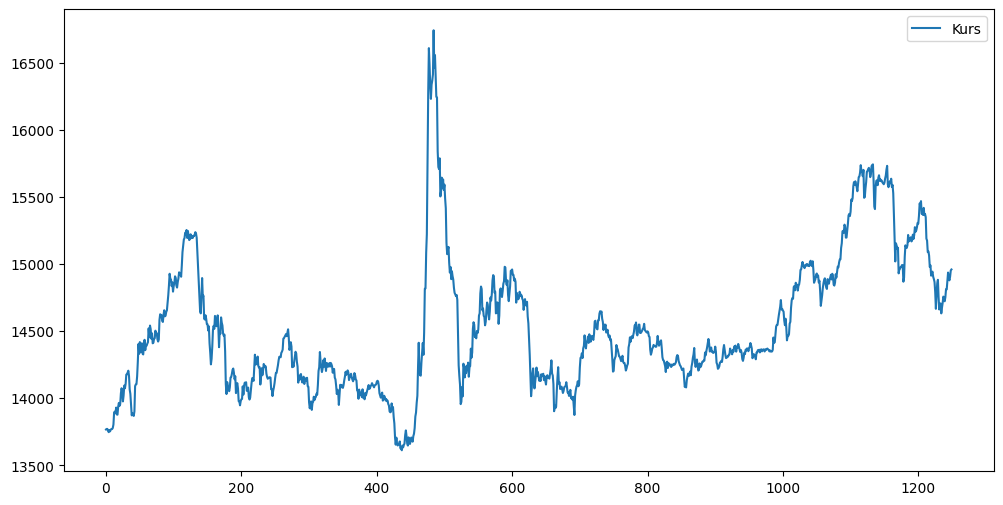

In [5]:
data_set.plot(figsize=(12,6))

# Mengubah Dataframe Menjadi Time Series

In [6]:
df = data_set['Kurs']
df

0       13767
1       13771
2       13771
3       13759
4       13747
        ...  
1245    14897
1246    14878
1247    14905
1248    14952
1249    14959
Name: Kurs, Length: 1250, dtype: int64

# Normalisasi

In [7]:
#Preprocessing data set
df = np.array(df).reshape(-1,1)

In [8]:
#Proses Scalling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = scaler.fit_transform(df)
print(df)

[[0.04953659]
 [0.05081496]
 [0.05081496]
 ...
 [0.41323106]
 [0.42825184]
 [0.43048897]]


# Membagi Data Training dan Data Testing

In [9]:
#Training and test sets
train = df[:1000]
test = df[1000:]
print(train.shape)
print(test.shape)

(1000, 1)
(250, 1)


# Membuat Fungsi Sliding/Look Back

In [10]:
def get_data(data, look_back):
    data_x, data_y = [],[]
    for i in range(len(data)-look_back-1):
        data_x.append(data[i:(i+look_back),0])
        data_y.append(data[i+look_back,0])
    return np.array(data_x) , np.array(data_y)

In [11]:
look_back = 1

In [12]:
x_train , y_train = get_data(train, look_back)
print(x_train.shape)
print(y_train.shape)

(998, 1)
(998,)


In [14]:
x_test , y_test = get_data(test,look_back)
print(x_test.shape)
print(y_test.shape)

(248, 1)
(248,)


# Reshape Data

In [15]:
#Processing train and test sets for LSTM model
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)
print(x_train.shape)
print(x_test.shape)

(998, 1, 1)
(248, 1, 1)


In [16]:
# Reshape y_train and y_test
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)
print(y_train.shape)
print(y_test.shape)

(998, 1)
(248, 1)


# Membangun Fungsi Pemodelan

In [17]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(y_train.shape[1], activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

# Tuning Hyperparameter

In [18]:
tuner= RandomSearch(
        build_model,
        objective='mse',
        max_trials=4,
        executions_per_trial=1
        )

In [19]:
tuner.search(
        x=x_train,
        y=y_train,
        epochs=20,
        batch_size=128,
        validation_data=(x_test,y_test),)
tuner.results_summary()

Trial 4 Complete [00h 00m 14s]
mse: 0.007903092540800571

Best mse So Far: 0.0005507602472789586
Total elapsed time: 00h 02m 49s
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="mse", direction="min")

Trial 0 summary
Hyperparameters:
input_unit: 128
n_layers: 3
lstm_0_units: 416
layer_2_neurons: 384
Dropout_rate: 0.30000000000000004
dense_activation: relu
lstm_1_units: 32
lstm_2_units: 32
Score: 0.0005507602472789586

Trial 1 summary
Hyperparameters:
input_unit: 288
n_layers: 3
lstm_0_units: 512
layer_2_neurons: 480
Dropout_rate: 0.2
dense_activation: sigmoid
lstm_1_units: 448
lstm_2_units: 480
Score: 0.0007334706024266779

Trial 2 summary
Hyperparameters:
input_unit: 32
n_layers: 2
lstm_0_units: 480
layer_2_neurons: 96
Dropout_rate: 0.30000000000000004
dense_activation: sigmoid
lstm_1_units: 64
lstm_2_units: 480
Score: 0.0012832223437726498

Trial 3 summary
Hyperparameters:
input_unit: 224
n_layers: 1
lstm_0_units: 96
layer_2_neurons: 32
Dropout_ra

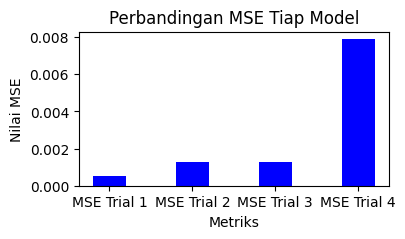

In [52]:
# Nilai MSE
mse_1 = 0.0005507602472789586
mse_2 = 0.0012832223437726498
mse_3 = 0.0012832223437726498
mse_4 = 0.007903092540800571

# Label untuk setiap data
label_data = ['MSE Trial 1', 'MSE Trial 2','MSE Trial 3','MSE Trial 4']

# Plot perbandingan RMSE
plt.figure(figsize=(4, 2))
plt.bar(label_data, [mse_1,mse_2,mse_3,mse_4], width=0.4, align='center', color=['blue', 'blue','blue','blue'])
plt.xlabel('Metriks')
plt.ylabel('Nilai MSE')
plt.title('Perbandingan MSE Tiap Model')
plt.show()

# Menentukan Model Terbaik

In [21]:
best_model = tuner.get_best_models(num_models=1)[0]

# Proses Forecasting

In [22]:
y_pred=best_model.predict(x_test)

8/8 [==============================] - 2s 6ms/step


# Hasil Forecasting

In [38]:
y_tests = scaler.inverse_transform(y_test)
print(y_tests)

[[14645.]
 [14578.]
 [14544.]
 [14592.]
 [14526.]
 [14431.]
 [14462.]
 [14464.]
 [14477.]
 [14555.]
 [14569.]
 [14672.]
 [14729.]
 [14746.]
 [14741.]
 [14828.]
 [14836.]
 [14804.]
 [14860.]
 [14835.]
 [14846.]
 [14802.]
 [14837.]
 [14848.]
 [14882.]
 [14956.]
 [14960.]
 [14990.]
 [15015.]
 [14986.]
 [14981.]
 [14969.]
 [14993.]
 [14985.]
 [14999.]
 [14999.]
 [14986.]
 [14992.]
 [14984.]
 [15017.]
 [15024.]
 [14992.]
 [14984.]
 [15020.]
 [14958.]
 [14860.]
 [14874.]
 [14888.]
 [14917.]
 [14929.]
 [14904.]
 [14915.]
 [14862.]
 [14875.]
 [14799.]
 [14688.]
 [14727.]
 [14767.]
 [14822.]
 [14858.]
 [14882.]
 [14893.]
 [14851.]
 [14827.]
 [14814.]
 [14887.]
 [14875.]
 [14853.]
 [14884.]
 [14900.]
 [14920.]
 [14885.]
 [14927.]
 [14905.]
 [14846.]
 [14839.]
 [14861.]
 [14923.]
 [14899.]
 [14939.]
 [14980.]
 [14975.]
 [15011.]
 [15033.]
 [15035.]
 [15119.]
 [15155.]
 [15243.]
 [15247.]
 [15232.]
 [15293.]
 [15276.]
 [15196.]
 [15197.]
 [15246.]
 [15299.]
 [15362.]
 [15373.]
 [15357.]
 [15390.]


In [39]:
#Bandingin dg data testing
y_pred_value = scaler.inverse_transform(y_pred)
print(y_pred_value)

[[14658.537 ]
 [14650.023 ]
 [14579.057 ]
 [14543.315 ]
 [14593.831 ]
 [14524.4795]
 [14426.191 ]
 [14458.042 ]
 [14460.104 ]
 [14473.533 ]
 [14554.856 ]
 [14569.576 ]
 [14678.789 ]
 [14739.766 ]
 [14758.003 ]
 [14752.636 ]
 [14846.178 ]
 [14854.792 ]
 [14820.345 ]
 [14880.634 ]
 [14853.714 ]
 [14865.558 ]
 [14818.193 ]
 [14855.867 ]
 [14867.711 ]
 [14904.319 ]
 [14983.897 ]
 [14988.191 ]
 [15020.367 ]
 [15047.127 ]
 [15016.081 ]
 [15010.722 ]
 [14997.852 ]
 [15023.581 ]
 [15015.01  ]
 [15030.006 ]
 [15030.006 ]
 [15016.081 ]
 [15022.51  ]
 [15013.937 ]
 [15049.265 ]
 [15056.747 ]
 [15022.51  ]
 [15013.937 ]
 [15052.472 ]
 [14986.045 ]
 [14880.634 ]
 [14895.707 ]
 [14910.778 ]
 [14941.984 ]
 [14954.889 ]
 [14927.998 ]
 [14939.832 ]
 [14882.786 ]
 [14896.783 ]
 [14814.965 ]
 [14695.875 ]
 [14737.621 ]
 [14780.556 ]
 [14839.719 ]
 [14878.479 ]
 [14904.319 ]
 [14916.16  ]
 [14870.942 ]
 [14845.101 ]
 [14831.107 ]
 [14909.702 ]
 [14896.783 ]
 [14873.096 ]
 [14906.473 ]
 [14923.693 ]
 [1494

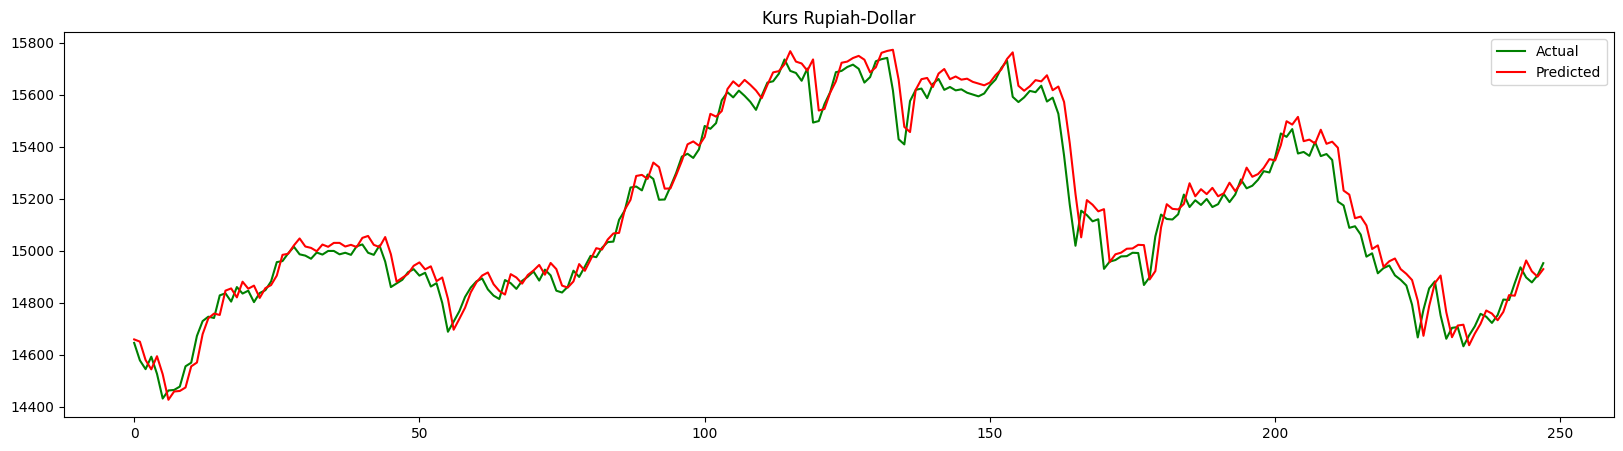

In [42]:
plt.figure(figsize=(20,5))
plt.title('Kurs Rupiah-Dollar')
plt.plot(y_tests , label = 'Actual', color = 'g')
plt.plot(y_pred_value , label = 'Predicted', color = 'r')
plt.legend()

In [43]:
import math
from sklearn.metrics import mean_squared_error
MSE = np.square(np.subtract(y_test,y_pred)).mean()
# Menghitung RMSE
RMSE_Testing = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE_Testing)

Root Mean Square Error:

0.021034478008228233


In [44]:
import math
from sklearn.metrics import mean_squared_error
# Menghitung RMSE
RMSE_Training = math.sqrt(0.0005507602472789586)
print("Root Mean Square Error:\n")
print(RMSE_Training)

Root Mean Square Error:

0.023468281728302107


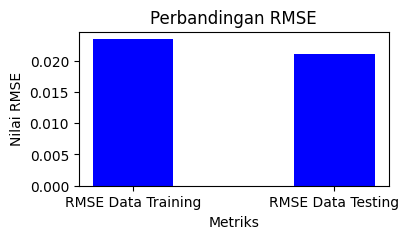

In [50]:
# Nilai MSE
rmse_1 = 0.023468281728302107
rmse_2 = 0.021034478008228233

# Label untuk setiap data
label_data = ['RMSE Data Training', 'RMSE Data Testing']

# Plot perbandingan RMSE
plt.figure(figsize=(4, 2))
plt.bar(label_data, [rmse_1,rmse_2], width=0.4, align='center', color=['blue', 'blue'])
plt.xlabel('Metriks')
plt.ylabel('Nilai RMSE')
plt.title('Perbandingan RMSE')
plt.show()